# Bird Sound Recognition with Tensorflow and MobileNet

The first thing you’d want to do is prepare your environment by importing relevant libraries and dependencies.



In [21]:
import numpy as np
import tensorflow as tf
import itertools
import os 
import shutil
import random
import pathlib
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

print(f"TensorFlow version {tf.__version__}")

TensorFlow version 2.15.0


# Prepare dataset

In [22]:
data_dir  = 'AY/step5-stft-resize-C/train'
test_dir  = 'AY/step5-stft-resize-C/test'
#data_dir  = 'AY/step8-mfcc-resize-C/train'
#test_dir  = 'AY/step8-mfcc-resize-C/test'

Split train dataset into train and val

In [23]:
BATCH_SIZE = 64
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=(224, 224),  # Adjust this to your desired image size
    batch_size=BATCH_SIZE  # Adjust batch size as needed
)
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

label_names = np.array(train_ds.class_names)
print()
print("Label names:", label_names)

train_ds.element_spec

Found 8000 files belonging to 10 classes.
Using 6400 files for training.
Using 1600 files for validation.

Label names: ['1-Mareca penelope' '10- Terpsiphone viridis' '2- American Robin'
 '3- Calaudalla cheleensis' '4- Cinnyris asiaticus' '5-Zenaida asiatica'
 '6- Lanius collurio' '7- Vanellus senegallus'
 '8- Phaethornis-longirostris' '9- Columba oenas']


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Take one batch and verify that your dataset is structured correctly and that the images and labels are the shape you expect

In [24]:
# get a few examples
for example_images, example_labels in train_ds.take(1):  
  print(example_images.shape)
  print(example_labels.shape)

(64, 224, 224, 3)
(64,)


In [25]:
# just checking the labels
label_names

array(['1-Mareca penelope', '10- Terpsiphone viridis',
       '2- American Robin', '3- Calaudalla cheleensis',
       '4- Cinnyris asiaticus', '5-Zenaida asiatica',
       '6- Lanius collurio', '7- Vanellus senegallus',
       '8- Phaethornis-longirostris', '9- Columba oenas'], dtype='<U27')

Show a few images

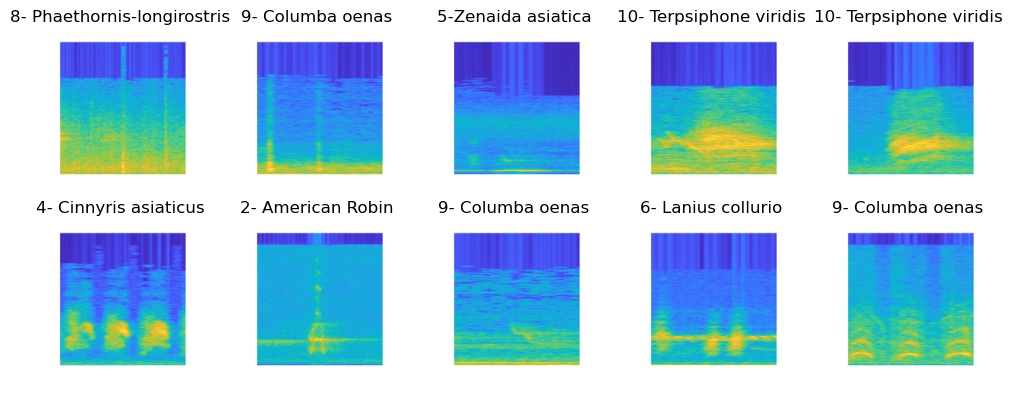

In [26]:
plt.figure(figsize=(10,4))
rows = 2
cols = 5
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

# Build and modify the MobileNet model


In [27]:
model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top = False)

# Build the base MobileNet model
for layer in model.layers:
    layer.trainable = False

# Add custom layers for classification
x = model.output
x = Flatten()(x)
#x = Dense(units=512, activation='relu')(x)
#x = Dense(units=256, activation='relu')(x)
x = Dense(units=len(label_names), activation='softmax', name='output_categorical')(x)

# Create the final model
new_model = Model(inputs=model.input, outputs=x)  # Use 'model.input' here

print(new_model.output_shape)
#new_model.summary()

'''
# Compile the model
new_model.compile(
#                optimizer=Adam(learning_rate=0.0001),
                optimizer=tf.keras.optimizers.Adam(),
#                loss='categorical_crossentropy',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
'''

new_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

(None, 10)


In [28]:
# train model
import time

EPOCHS = 10

start = time.monotonic()

history = new_model.fit(
                    train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks = [tf.keras.callbacks.EarlyStopping(verbose=1, patience=2, mode='min')]
)

training_time = time.monotonic()-start
print(f"Total training time: {training_time:.2f} seconds")

Epoch 1/10
100/100 [==============================] - 10s 77ms/step - loss: 3.1455 - accuracy: 0.7550 - val_loss: 0.2427 - val_accuracy: 0.9453
Epoch 2/10
100/100 [==============================] - 7s 72ms/step - loss: 0.1117 - accuracy: 0.9702 - val_loss: 0.1633 - val_accuracy: 0.9661
Epoch 3/10
100/100 [==============================] - 8s 75ms/step - loss: 0.0402 - accuracy: 0.9862 - val_loss: 0.1363 - val_accuracy: 0.9635
Epoch 4/10
100/100 [==============================] - 8s 75ms/step - loss: 0.0221 - accuracy: 0.9925 - val_loss: 0.1347 - val_accuracy: 0.9766
Epoch 5/10
100/100 [==============================] - 8s 77ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.1166 - val_accuracy: 0.9753
Epoch 6/10
100/100 [==============================] - 8s 74ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0938 - val_accuracy: 0.9805
Epoch 7/10
100/100 [==============================] - 8s 74ms/step - loss: 3.9634e-04 - accuracy: 1.0000 - val_loss: 0.0880 - val_accuracy: 0

Text(0, 0.5, 'Accuracy [%]')

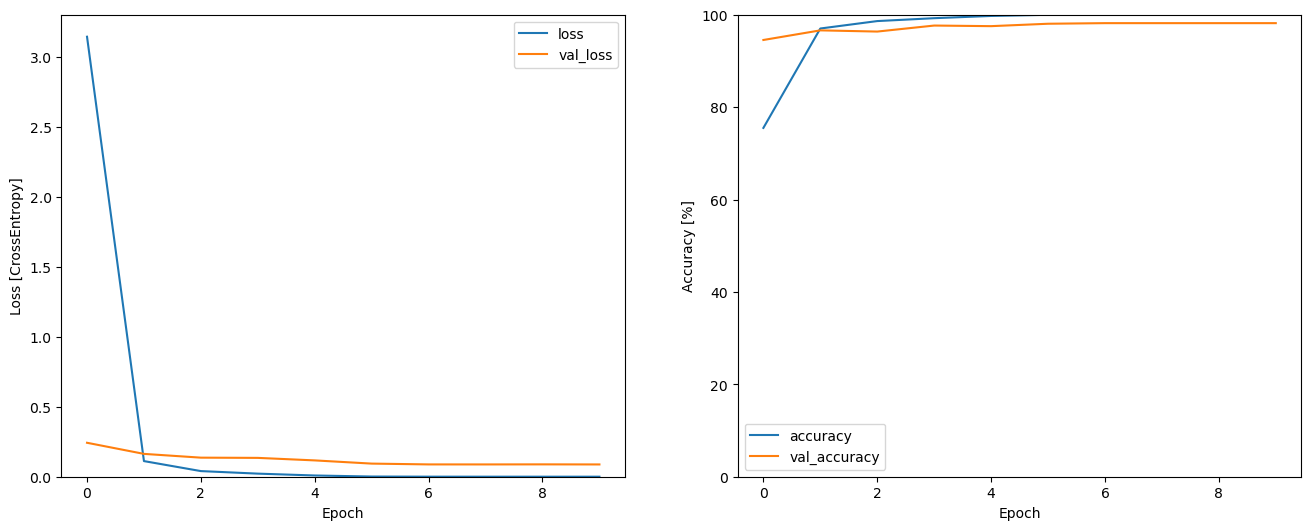

In [29]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Evaluate the model performance

In [30]:
#
new_model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 1s 68ms/step - loss: 0.1362 - accuracy: 0.9724


{'loss': 0.1361958235502243, 'accuracy': 0.9723557829856873}

In [31]:
y_pred = new_model.predict(test_ds)

13/13 [==============================] - 1s 57ms/step


In [32]:
y_pred = tf.argmax(y_pred, axis=1)

In [33]:
y_true = tf.concat(list(test_ds.map(lambda s,lab: lab)), axis=0)

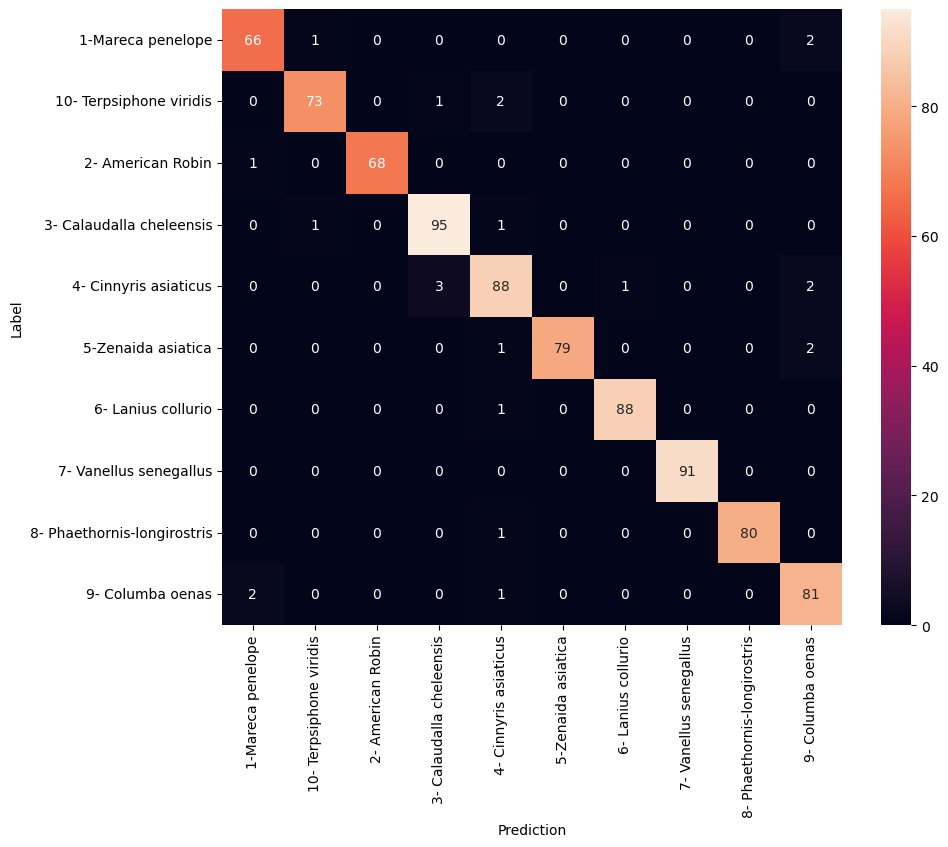

In [40]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('stft_predictions.png')

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))

                             precision    recall  f1-score   support

          1-Mareca penelope       0.96      0.96      0.96        69
    10- Terpsiphone viridis       0.97      0.96      0.97        76
          2- American Robin       1.00      0.99      0.99        69
   3- Calaudalla cheleensis       0.96      0.98      0.97        97
      4- Cinnyris asiaticus       0.93      0.94      0.93        94
         5-Zenaida asiatica       1.00      0.96      0.98        82
         6- Lanius collurio       0.99      0.99      0.99        89
     7- Vanellus senegallus       1.00      1.00      1.00        91
8- Phaethornis-longirostris       1.00      0.99      0.99        81
           9- Columba oenas       0.93      0.96      0.95        84

                   accuracy                           0.97       832
                  macro avg       0.97      0.97      0.97       832
               weighted avg       0.97      0.97      0.97       832



In [36]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
#    seed=seed,
    image_size=(224, 224),  # Adjust this to your desired image size
#    batch_size=BATCH_SIZE  # Adjust batch size as needed
)

new_model.evaluate(test_ds, return_dict=True)
#my_pred = new_model.predict(test_ds)
my_pred = new_model.predict(test_ds, steps=len(test_ds))
my_pred = tf.argmax(my_pred, axis=1)
my_true = tf.concat(list(test_ds.map(lambda s,lab: lab)), axis=0)

Found 2000 files belonging to 10 classes.
63/63 [==============================] - 2s 31ms/step


In [37]:
unique, counts = np.unique(my_true, return_counts=True)
print(dict(zip(unique, counts)))

{0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}


In [38]:
from sklearn.metrics import classification_report
print(classification_report(my_true, my_pred, target_names=label_names))

                             precision    recall  f1-score   support

          1-Mareca penelope       0.08      0.08      0.08       200
    10- Terpsiphone viridis       0.12      0.12      0.12       200
          2- American Robin       0.05      0.05      0.05       200
   3- Calaudalla cheleensis       0.14      0.14      0.14       200
      4- Cinnyris asiaticus       0.09      0.09      0.09       200
         5-Zenaida asiatica       0.09      0.09      0.09       200
         6- Lanius collurio       0.10      0.10      0.10       200
     7- Vanellus senegallus       0.11      0.11      0.11       200
8- Phaethornis-longirostris       0.10      0.10      0.10       200
           9- Columba oenas       0.09      0.09      0.09       200

                   accuracy                           0.10      2000
                  macro avg       0.10      0.10      0.10      2000
               weighted avg       0.10      0.10      0.10      2000

